### 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [43]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [44]:
# Configure API key 

quandl.ApiConfig.api_key = 'x1TE6ZDjX8HJcE_2hsSM'

In [45]:
# Importing the Organization of the Petroleum Exporting Countries "OPEC Crude Oil Price" variable.

data = quandl.get('OPEC/ORB')

In [46]:
data.head(10)

Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
2003-01-09  29.51
2003-01-10  29.82
2003-01-13  29.82
2003-01-14  30.21
2003-01-15  30.66

In [47]:
data.shape

(5286, 1)

In [48]:
data.columns

Index(['Value'], dtype='object')

In [49]:
type(data)

pandas.core.frame.DataFrame

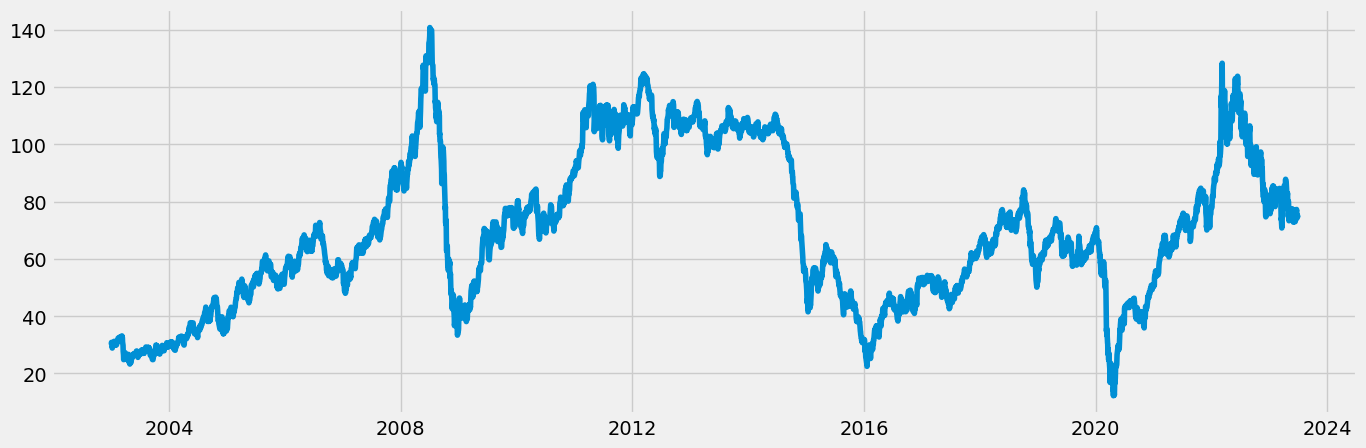

In [50]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [51]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [52]:
data_2.head()

Date  Value
0 2003-01-02  30.05
1 2003-01-03  30.83
2 2003-01-06  30.71
3 2003-01-07  29.72
4 2003-01-08  28.86

In [53]:
# Data sub for the Post-Covid Pandemic Era

data_sub = data_2.loc[(data_2['Date'] >= '2021-01-01') & (data_2['Date'] < '2023-03-31')]

##### logic followed when selecting the data_sub data points.

The data_sub data points were specifically chosen to understand the trend of "OPEC Crude Oil Price" after the Covid-19 pandemic of 2020.

In [54]:
data_sub.shape

(580, 2)

In [55]:
data_sub.head()

Date  Value
4643 2021-01-04  51.35
4644 2021-01-05  50.75
4645 2021-01-06  53.29
4646 2021-01-07  53.84
4647 2021-01-08  54.39

In [56]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

Value
datetime         
2021-01-04  51.35
2021-01-05  50.75
2021-01-06  53.29
2021-01-07  53.84
2021-01-08  54.39

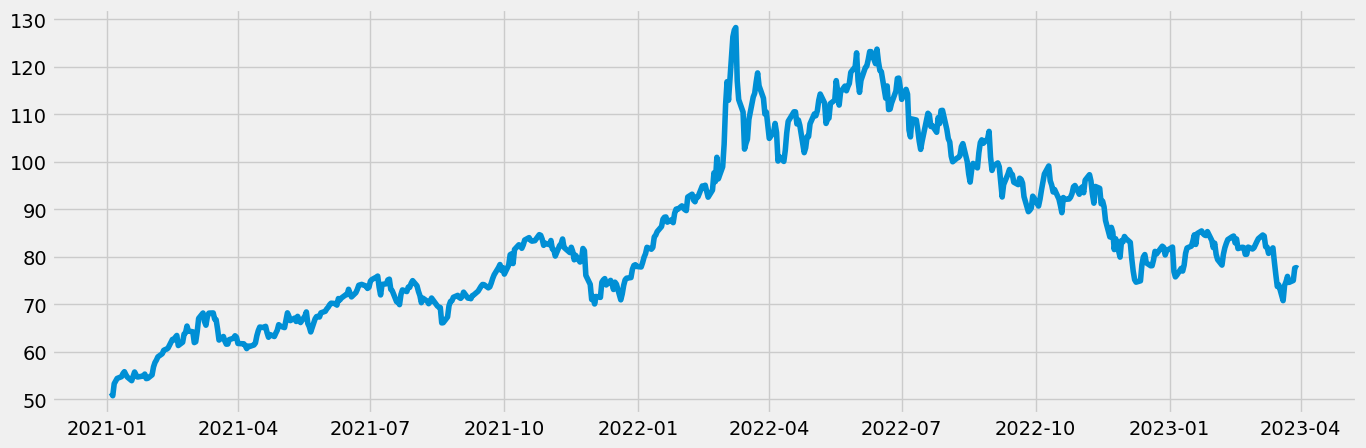

In [57]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [58]:
# Check for missing values

data_sub.isnull().sum() 

# No missing values!

Value    0
dtype: int64

In [59]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# 23 duplicates found!

23

In [60]:
# Drop all duplicates

data_sub_2 = data_sub.drop_duplicates()

In [61]:
data_sub_2.shape

(557, 1)

In [62]:
# 580 - 23 = 557 (All duplicates removed)

In [63]:
data_sub_2.sort_index(inplace=True)

In [64]:
data_sub_2.head()

Value
datetime         
2021-01-04  51.35
2021-01-05  50.75
2021-01-06  53.29
2021-01-07  53.84
2021-01-08  54.39

### 3. Time-series analysis: decomposition

In [65]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub_2, model='additive', period= 15) 

In [66]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

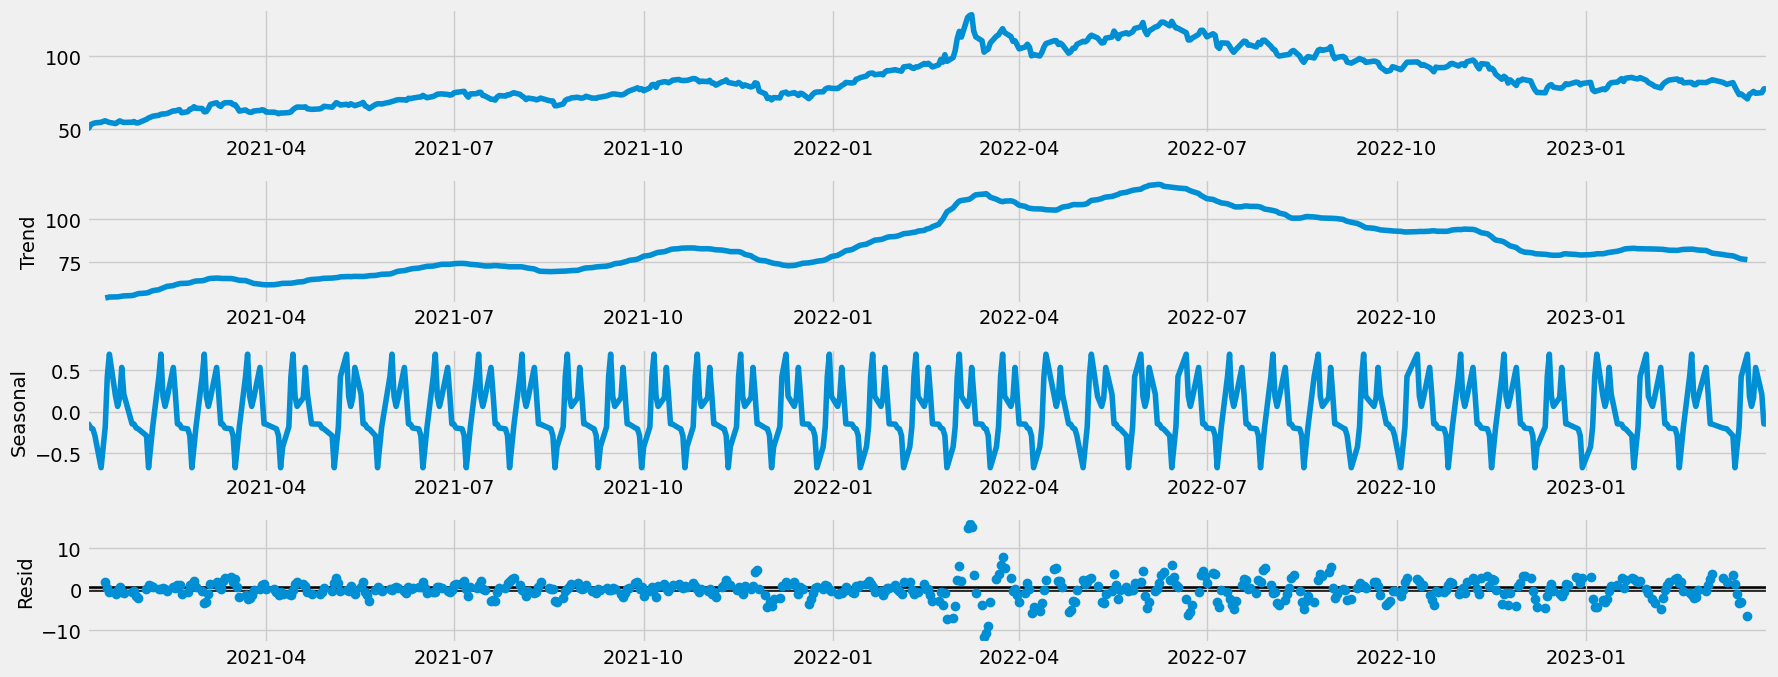

In [67]:
# Plot the separate components

fig = decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [68]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.721151
p-value                          0.420249
Number of Lags Used              8.000000
Number of Observations Used    548.000000
Critical Value (1%)             -3.442339
Critical Value (5%)             -2.866829
Critical Value (10%)            -2.569587
dtype: float64


###### The test statistic (-1.7211) is greater than the critical values at 1% (-3.4433), 5% (-2.8668), and at 10% (-2.5695) hence, we cannot reject the Null hypothesis.

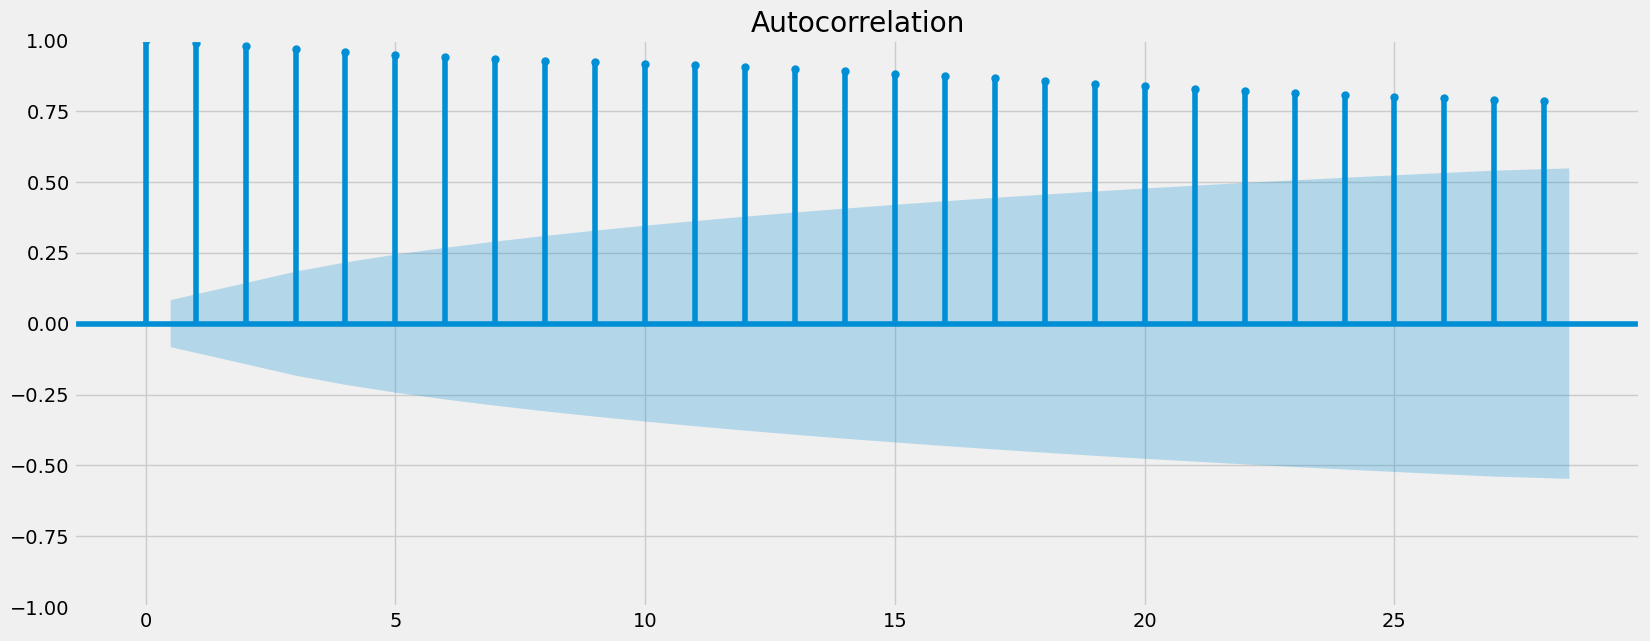

In [69]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub_2)
plt.show()

###### All lines went above the blue edge of the confidence interval, this means all lags are significantly correlated with each other. We can then deduce that our data is non-stationary.

### 5. Stationarizing the OPEC Crude Oil Price Data

In [70]:
# Conduct differncing to stationarize the data.

data_diff = data_sub_2 - data_sub_2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [71]:
# Remove the missing values

data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [72]:
# Check the head

data_diff.head()

Value
datetime         
2021-01-05  -0.60
2021-01-06   2.54
2021-01-07   0.55
2021-01-08   0.55
2021-01-11   0.37

In [73]:
# Check the columns

data_diff.columns

Index(['Value'], dtype='object')

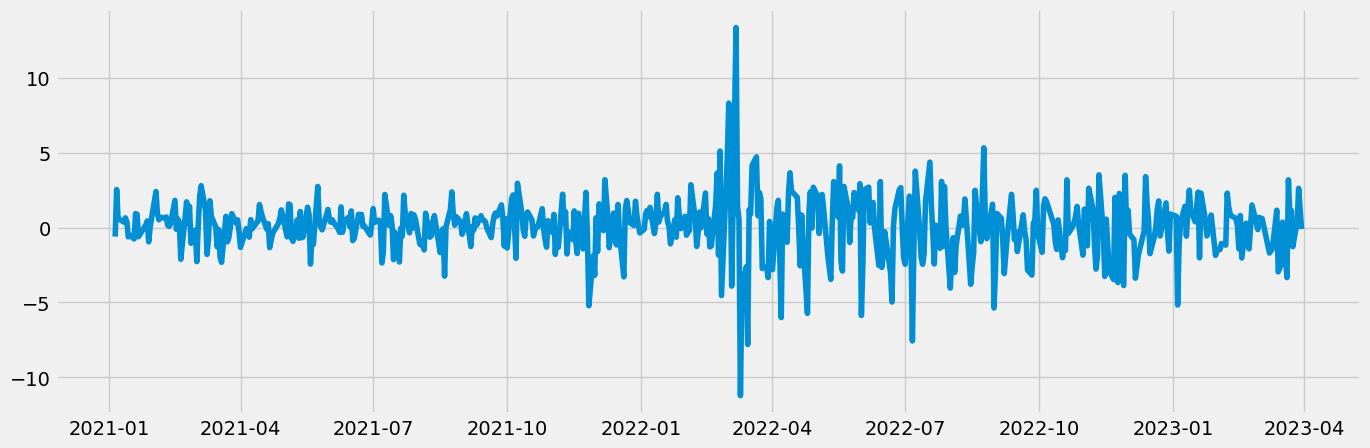

In [74]:
# Check out the effect of differencing on the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [75]:
# Conduct Dickey-Fuller test

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.097643e+01
p-value                        7.649071e-20
Number of Lags Used            7.000000e+00
Number of Observations Used    5.480000e+02
Critical Value (1%)           -3.442339e+00
Critical Value (5%)           -2.866829e+00
Critical Value (10%)          -2.569587e+00
dtype: float64


##### The test statistic (-10.9764) is smaller than the critical values at 1% (-3.4423), 5% (-2.8668), and at 10% (-2.5695) hence, we reject the Null hypothesis.

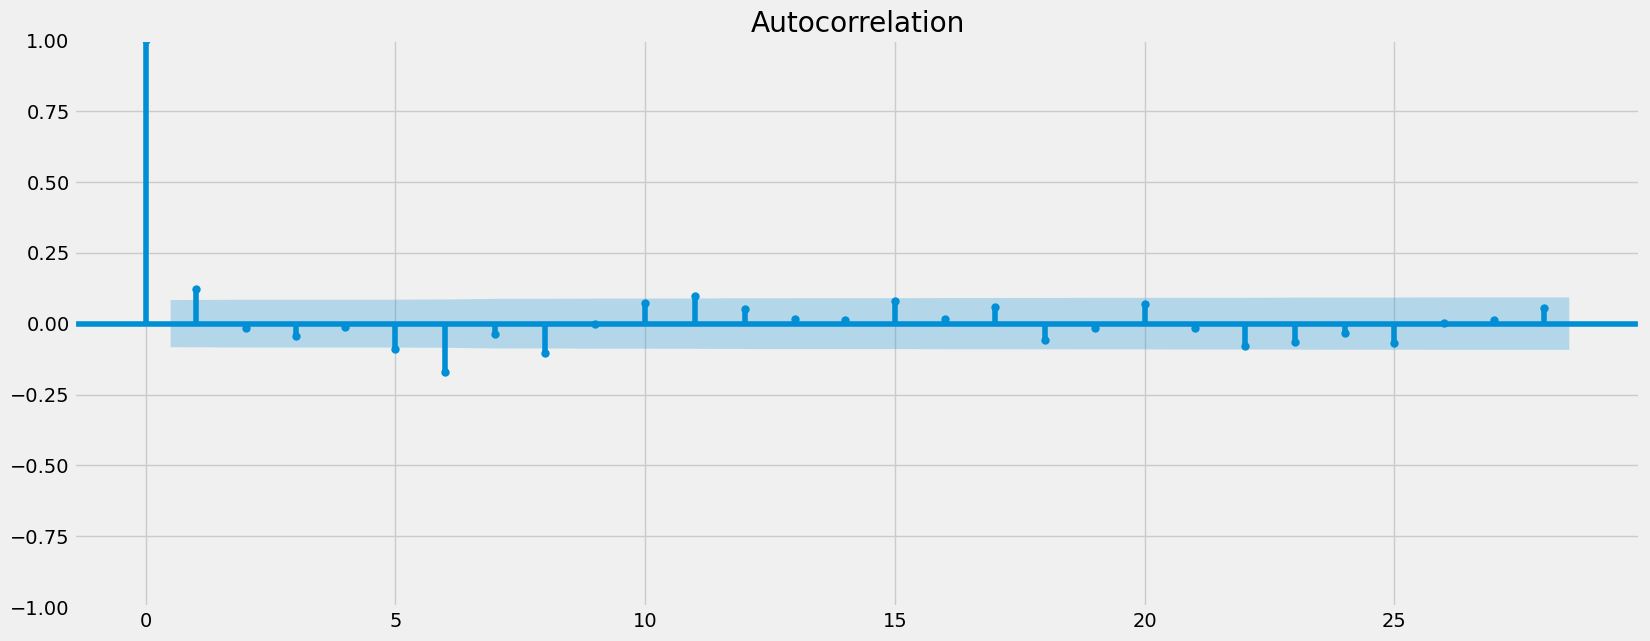

In [77]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

###### The autocorrelation plot has improved as only few of the lines (about six) went above the blue edge of the confidence interval, this means only few lags are significantly correlated with each other. This represents a very weak stationarity, hence we need to conduct another set of differencing.

In [78]:
# Conduct another round of differncing to stationarize the data.

data_diff_2 = data_diff - data_diff.shift(1)

In [79]:
# Remove the missing values that came about as a result of the differencing.

data_diff_2.dropna(inplace = True) 

In [80]:
# Check the head

data_diff_2.head()

Value
datetime                
2021-01-06  3.140000e+00
2021-01-07 -1.990000e+00
2021-01-08 -7.105427e-15
2021-01-11 -1.800000e-01
2021-01-12  2.800000e-01

In [82]:
# Check the columns

data_diff_2.columns

Index(['Value'], dtype='object')

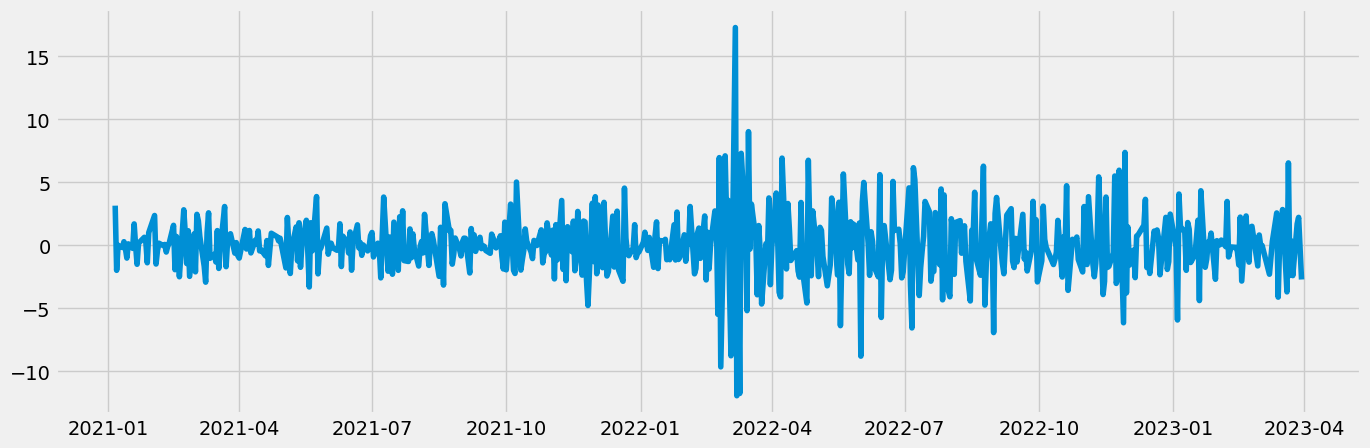

In [83]:
# Check out the effect of second round of differencing on the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [84]:
# Conduct Dickey-Fuller test

dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.076048e+01
p-value                        2.528348e-19
Number of Lags Used            1.800000e+01
Number of Observations Used    5.360000e+02
Critical Value (1%)           -3.442609e+00
Critical Value (5%)           -2.866947e+00
Critical Value (10%)          -2.569650e+00
dtype: float64


##### The test statistic (-10.7604) is still smaller than the critical values at 1% (-3.4423), 5% (-2.8668), and at 10% (-2.5695) hence, we reject the Null hypothesis.

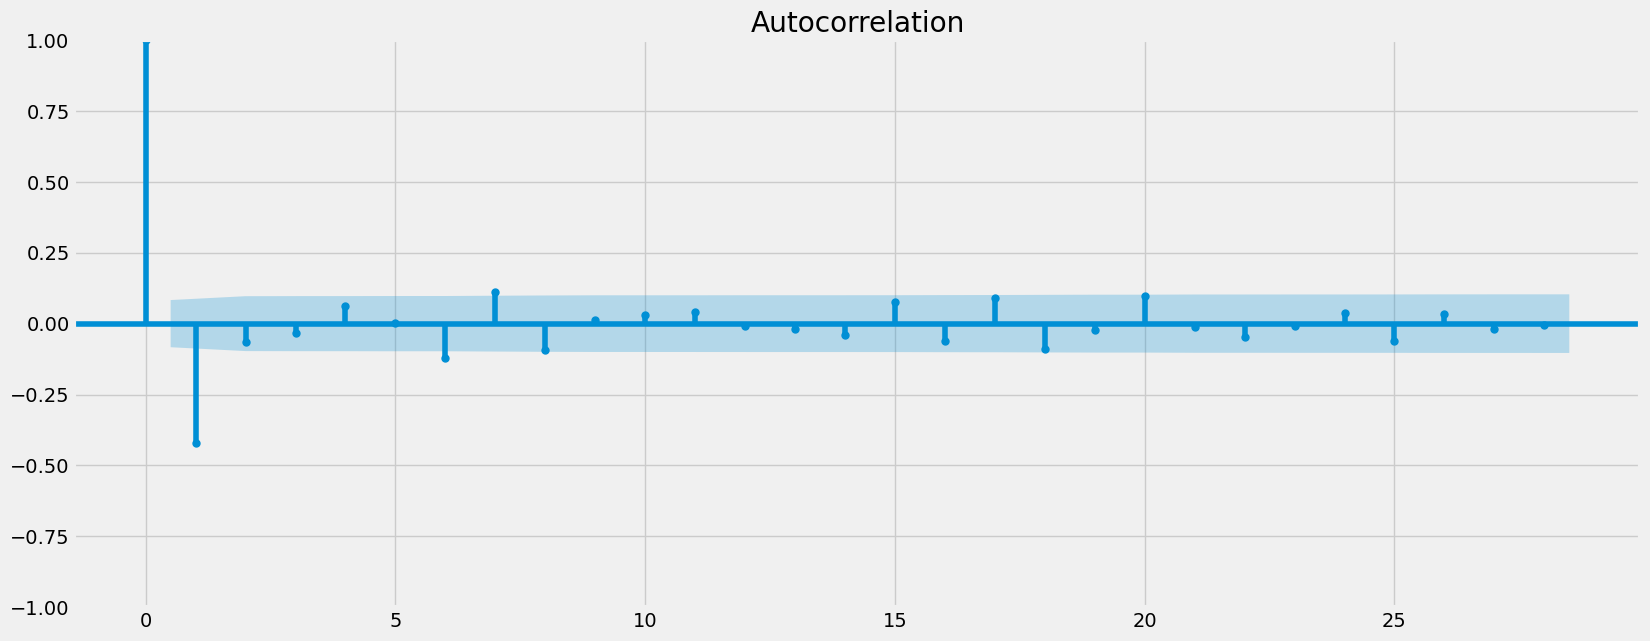

In [85]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show()

###### The autocorrelation plot improved as fewer lines (about four) went above the blue edge of the confidence interval, this means only few lags are significantly correlated with each other. This represents a weak stationarity but agrees with the dickey_fuller test result.